# Next-Generation Application of Reservoir Computing
Author: Alvin B. Lin\
Last Update: 01/02/2026\
Reference: Gauthier, D. J., et al. (2021). "Next generation reservoir computing." Nature Communications, 12(1), 5564.


## Introduction
The paper *Next generation reservoir computing* introduces a method to predict dynamical systems by replacing traditional neural networks with **Nonlinear Vector Autoregression (NVAR)**.
### Core Concept: NG-RC (NVAR)
The Next-Generation Reservoir Computer (NG-RC) eliminates the need for random matrices and hidden neurons. Instead, it uses a deterministic feature vector created directly from the input data:
- Linear Part: A time-delay embedding of the input $X$ at $k$ previous steps.
- Nonlinear Part: Unique monomials (polynomials) of the linear components.The
### Method
- Feature Vector: Construct $\mathbb{O}_{total}$ as $1 \oplus \mathbb{O}_{lin} \oplus \mathbb{O}_{nonlin}$.
- Training: Solve for the output weights $W_{out}$ using Ridge Regression to map the features to the desired output.
- Euler Step: For forecasting, the model learns the change between steps: $X_{i+1} = X_i + W_{out}\mathbb{O}_{total,i}$.
### Key Advantages
- Efficiency: It is $33$ to $162$ times less computationally expensive than traditional RCs.
- Data Savings: Requires extremely small training sets ($400$ points) and a minimal "warm-up" (as few as $2$ points).
- Interpretability: Since it uses explicit polynomials rather than random networks, the results are easier to analyze.

## Algorithm
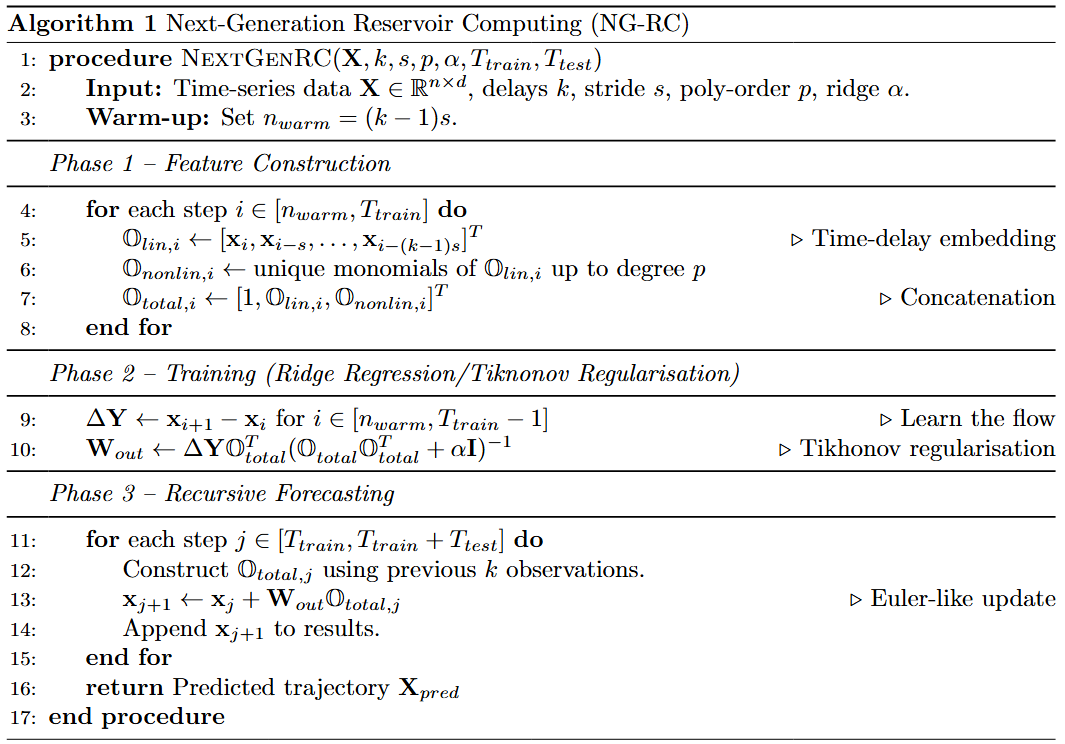

## Creating a Class for Prediction Convenience

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Ridge

class NextGenRC:
    def __init__(self, d, k, s, poly_order=2, ridge_alpha=1e-6):
        self.d = d                 # Dimension of the system (e.g., 3 for Lorenz)
        self.k = k                 # Number of time-delay taps
        self.s = s                 # Stride between taps
        self.poly_order = poly_order
        self.ridge_alpha = ridge_alpha
        self.warmup = (k - 1) * s  # Minimum points needed to start
        self.W_out = None

    def _get_unique_monomials(self, O_lin):
        """Constructs the nonlinear part of the feature vector."""
        if self.poly_order == 2:
            # Quadratic: d(d+1)/2 terms [cite: 176]
            return np.array([O_lin[i] * O_lin[j]
                             for i in range(len(O_lin))
                             for j in range(i, len(O_lin))])
        elif self.poly_order == 3:
            # Cubic: d(d+1)(d+2)/6 terms (used for Double-Scroll)
            return np.array([O_lin[i] * O_lin[j] * O_lin[l]
                             for i in range(len(O_lin))
                             for j in range(i, len(O_lin))
                             for l in range(j, len(O_lin))])
        return np.array([])

    def build_features(self, data):
        """Creates O_total = c ⊕ O_lin ⊕ O_nonlin."""
        features = []
        for i in range(self.warmup, len(data)):
            # Linear delay-coordinate embedding
            O_lin = np.concatenate([data[i - j*self.s] for j in range(self.k)])
            O_nonlin = self._get_unique_monomials(O_lin)
            # Combine with constant term
            features.append(np.concatenate([[1.0], O_lin, O_nonlin]))
        return np.array(features)

    def train(self, data):
        """Learns the 'flow' (Euler step) using Ridge Regression."""
        O_total = self.build_features(data)
        # Target is the increment: X[i+1] - X[i]
        Y_target = data[self.warmup + 1:] - data[self.warmup : -1]

        # Ridge solver (Tikhonov regularization)
        solver = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        solver.fit(O_total[:-1], Y_target)
        self.W_out = solver.coef_

    def forecast(self, start_sequence, steps):
        """Autonomous recursive prediction."""
        history = list(start_sequence)
        for _ in range(steps):
            window = np.array(history[- (self.warmup + 1):])
            O_t = self.build_features(window)[-1]

            # X_{i+1} = X_i + W_out @ O_t
            delta_X = self.W_out @ O_t
            history.append(history[-1] + delta_X)
        return np.array(history[self.warmup + 1:])

## Set up Plotting Format

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ng_rc_results(t, data, prediction, train_idx, system_name="System"):
    """
    Generates paper-style visualization for NG-RC performance.
    Adapted to handle flexible dimensions d while maintaining the original layout.
    """
    # Detect system dimension
    d = data.shape[1]

    # Configuration for aesthetics matching the paper
    t_linewidth = 1.1
    a_linewidth = 0.5
    plt.rcParams.update({'font.size': 10})

    # Create the figure with grid layout
    fig = plt.figure(figsize=(14, 3 * d)) # Dynamic height based on d
    fig.suptitle(system_name, fontsize=24)
    h, w = 120, 100

    # --- TOP ROW: Attractor Phase Space (Variable 1 vs Variable 3) ---
    # Top panels are standard in the paper for Lorenz63 and Double-Scroll
    ax1 = plt.subplot2grid((h, w), (0, 5), colspan=35, rowspan=40)
    ax1.plot(data[train_idx:, 0], data[train_idx:, 2 if d >= 3 else 1],
             linewidth=a_linewidth, color='tab:blue')
    ax1.set_title('ground truth')
    ax1.set_xlabel('Variable 1 ($x$)')
    ax1.set_ylabel(f'Variable {3 if d >= 3 else 2} ($z$)')

    ax5 = plt.subplot2grid((h, w), (0, 55), colspan=35, rowspan=40)
    ax5.plot(prediction[:, 0], prediction[:, 2 if d >= 3 else 1],
             linewidth=a_linewidth, color='red')
    ax5.set_title('NG-RC prediction')
    ax5.set_xlabel('Variable 1 ($x$)')
    ax5.set_ylabel(f'Variable {3 if d >= 3 else 2} ($z$)')

    # --- MIDDLE & BOTTOM: Time Series Splits ---
    # Calculate vertical spacing for d variables
    row_height = int(60 / d)

    t_train = t[:train_idx]
    t_test = t[train_idx:]

    for i in range(d):
        # Training Phase Columns (Left) - [cite: 303, 348]
        ax_train = plt.subplot2grid((h, w), (55 + i*row_height, 0), colspan=45, rowspan=row_height-4)
        ax_train.plot(t_train, data[:train_idx, i], color='tab:blue', linewidth=t_linewidth)
        ax_train.set_ylabel(f'Var {i+1}')

        # Testing Phase Columns (Right) - [cite: 305, 348]
        ax_test = plt.subplot2grid((h, w), (55 + i*row_height, 55), colspan=45, rowspan=row_height-4)
        ax_test.plot(t_test, data[train_idx:, i], color='tab:blue', linewidth=t_linewidth, label='Actual')
        ax_test.plot(t_test, prediction[:, i], color='red', linewidth=t_linewidth, linestyle='--', label='Forecast')

        # Clean up labels
        if i == 0:
            ax_train.set_title('training phase')
            ax_test.set_title('testing phase')
        if i < d - 1:
            ax_train.set_xticklabels([])
            ax_test.set_xticklabels([])
        else:
            ax_train.set_xlabel('time')
            ax_test.set_xlabel('time')

    plt.show()

## Testing for Lorenz63 System

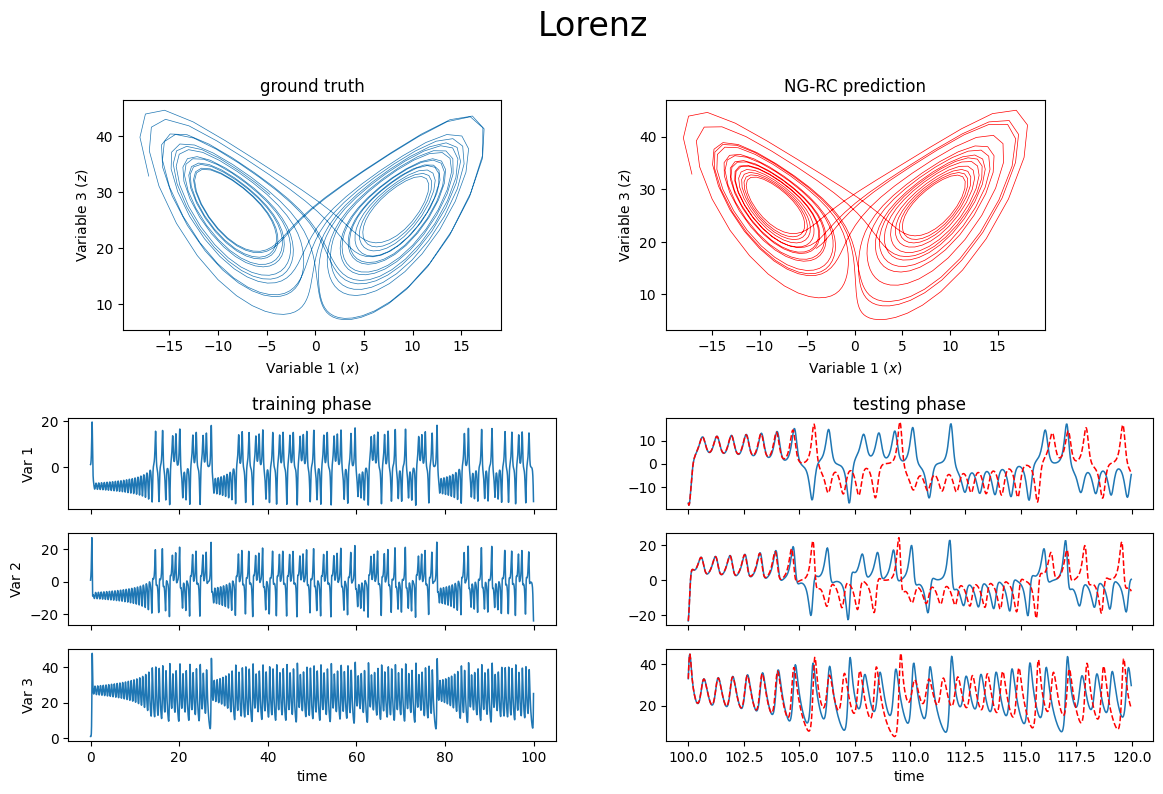

In [49]:
def lorenz_system(t_span, dt, init_state=[1.0, 1.0, 1.0]):
    def odes(t, y):
        return [10*(y[1]-y[0]), y[0]*(28-y[2])-y[1], y[0]*y[1]-8/3*y[2]]
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(odes, t_span, init_state, t_eval=t_eval, method='RK45')
    return sol.t, sol.y.T

# --- USER CONFIGURATION ---
SYSTEM = 'Lorenz'
TRAIN_TIME = 100.0
TEST_TIME = 20.0
dt = 0.025
t, data = lorenz_system((0, TRAIN_TIME + TEST_TIME), dt)
# Param d=3, k=2, poly=2
model = NextGenRC(d=3, k=2, s=1, poly_order=2, ridge_alpha=2.5e-6)

# --- SPLIT, TRAIN, FORECAST ---
train_idx = int(TRAIN_TIME / dt)
train_set = data[:train_idx]
model.train(train_set)

# Forecast using the last snippet of training data as the start
pred_steps = len(t) - train_idx
prediction = model.forecast(train_set[-(model.warmup+1):], pred_steps)

# --- PLOT RESULTS ---
plot_ng_rc_results(t, data, prediction, train_idx, system_name=SYSTEM)

## Test for Double Scroll System

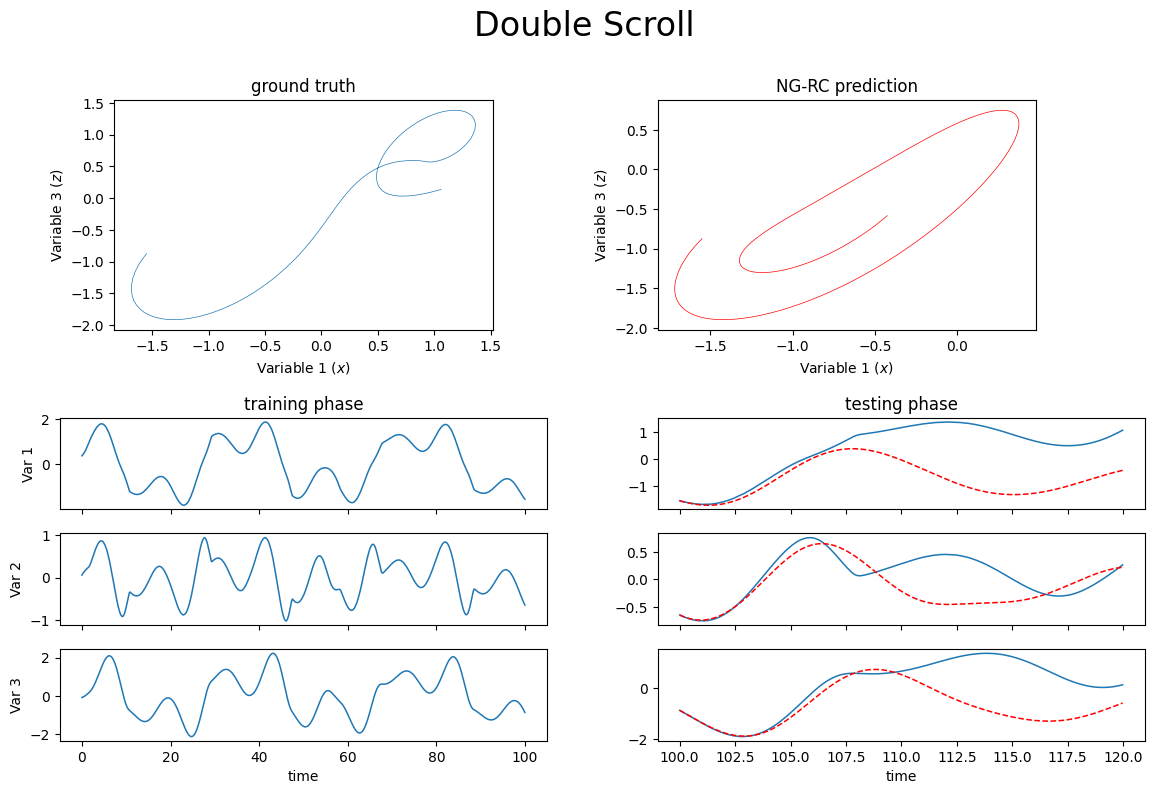

In [50]:
def double_scroll_system(t_span, dt, init_state=[0.379, 0.058, -0.081]):
    r1, r2, r4, alpha, ir = 1.2, 3.44, 0.193, 11.6, 4.5e-5
    def odes(t, y):
        dV = y[0]-y[1]
        g = (dV/r2) + ir*np.sinh(alpha*dV)
        return [(y[0]/r1)-g, g-y[2], y[1]-r4*y[2]]
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(odes, t_span, init_state, t_eval=t_eval, method='RK23')
    return sol.t, sol.y.T

# --- USER CONFIGURATION ---
SYSTEM = 'Double Scroll'
TRAIN_TIME = 100.0
TEST_TIME = 20.0
dt = 0.025
t, data = double_scroll_system((0, TRAIN_TIME + TEST_TIME), dt)
# Param d=3, k=2, poly=2
model = NextGenRC(d=3, k=2, s=1, poly_order=2, ridge_alpha=2.5e-6)

# --- SPLIT, TRAIN, FORECAST ---
train_idx = int(TRAIN_TIME / dt)
train_set = data[:train_idx]
model.train(train_set)

# Forecast using the last snippet of training data as the start
pred_steps = len(t) - train_idx
prediction = model.forecast(train_set[-(model.warmup+1):], pred_steps)

# --- PLOT RESULTS ---
plot_ng_rc_results(t, data, prediction, train_idx, system_name=SYSTEM)

## Test for Predator-Prey Model

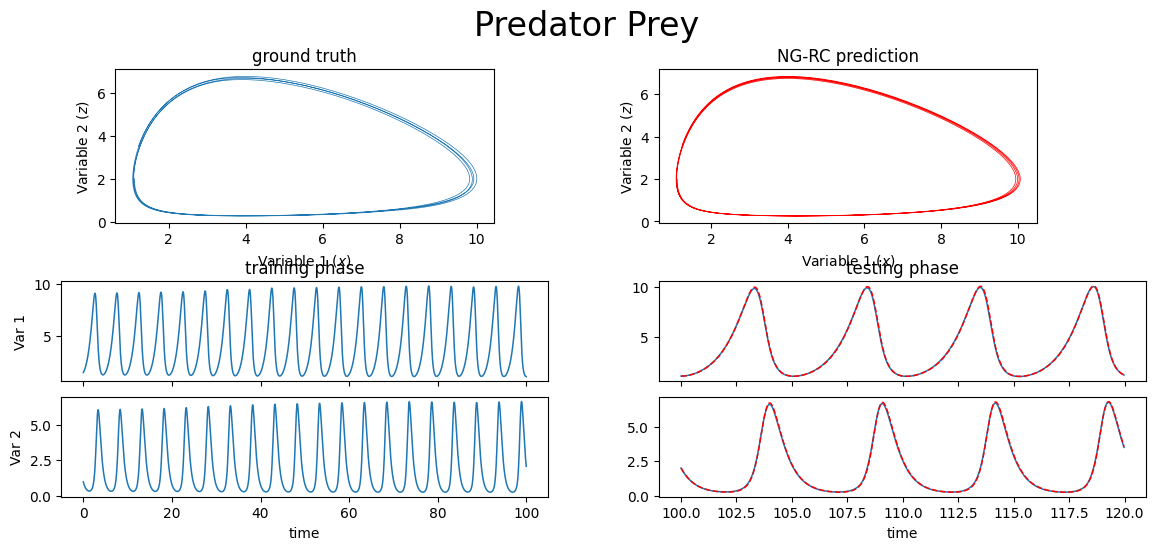

In [52]:
def predator_prey(t_span, dt, init_state=[1.5,1], alpha=1.0, beta=0.5, delta=0.5, gamma=2.0):
    """
    Lotka–Volterra predator–prey model
    """
    def odes(t, y):
      prey, predator = y
      return [alpha * prey - beta * prey * predator, delta * prey * predator - gamma * predator]
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(odes, t_span, init_state, t_eval=t_eval, method='RK45')
    return sol.t, sol.y.T

# --- USER CONFIGURATION ---
SYSTEM = 'Predator Prey'
TRAIN_TIME = 100.0
TEST_TIME = 20.0
dt = 0.025
t, data = predator_prey((0, TRAIN_TIME + TEST_TIME), dt)
# Param d=3, k=2, poly=2
model = NextGenRC(d=3, k=2, s=1, poly_order=2, ridge_alpha=2.5e-6)

# --- SPLIT, TRAIN, FORECAST ---
train_idx = int(TRAIN_TIME / dt)
train_set = data[:train_idx]
model.train(train_set)

# Forecast using the last snippet of training data as the start
pred_steps = len(t) - train_idx
prediction = model.forecast(train_set[-(model.warmup+1):], pred_steps)

# --- PLOT RESULTS ---
plot_ng_rc_results(t, data, prediction, train_idx, system_name=SYSTEM)

## Test for Rössler System

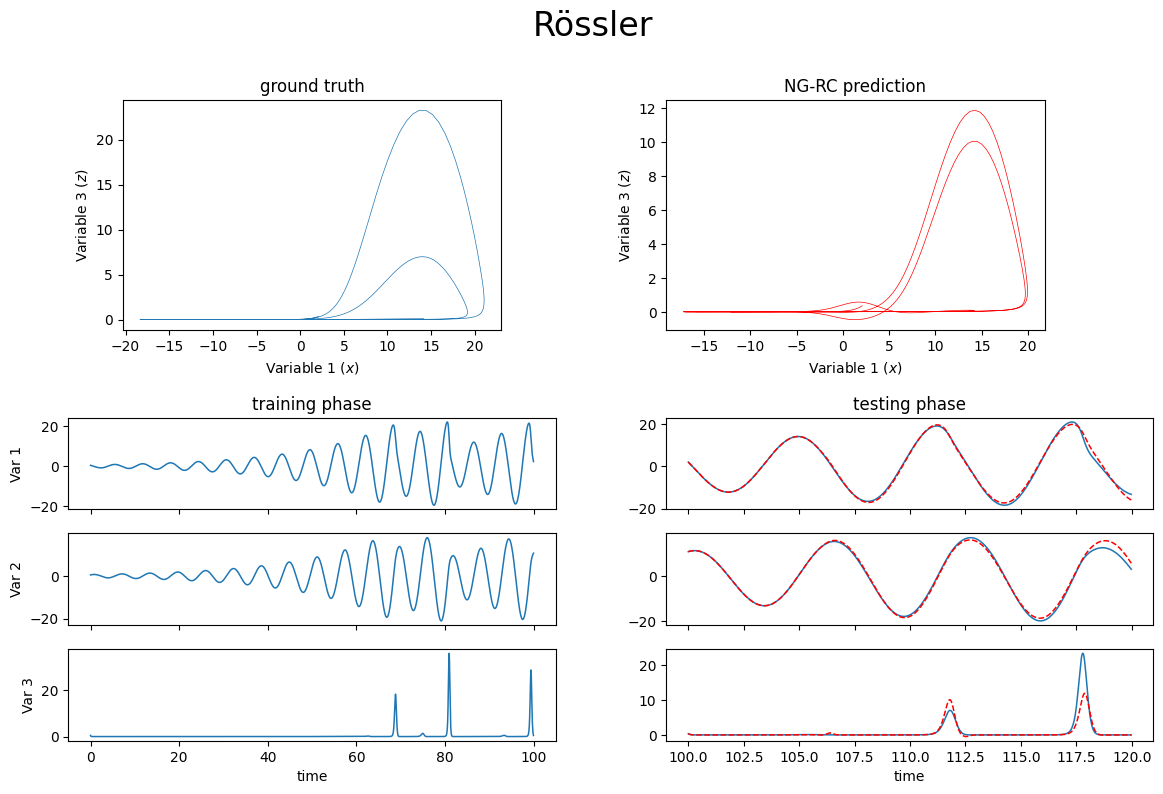

In [53]:
def rossler(t_span, dt, init_state=[0.5,0.5,0.5], a=0.1, b=0.1, c=14):
    """
    Lotka–Volterra predator–prey model
    """
    def odes(t, y):
      u, v, w = y
      return [-v - w, u + a * v, b + w * (u - c)]
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(odes, t_span, init_state, t_eval=t_eval, method='RK45')
    return sol.t, sol.y.T

# --- USER CONFIGURATION ---
SYSTEM = 'Rössler'
TRAIN_TIME = 100.0
TEST_TIME = 20.0
dt = 0.025
t, data = rossler((0, TRAIN_TIME + TEST_TIME), dt)
# Param d=3, k=2, poly=2
model = NextGenRC(d=3, k=2, s=1, poly_order=2, ridge_alpha=2.5e-6)

# --- SPLIT, TRAIN, FORECAST ---
train_idx = int(TRAIN_TIME / dt)
train_set = data[:train_idx]
model.train(train_set)

# Forecast using the last snippet of training data as the start
pred_steps = len(t) - train_idx
prediction = model.forecast(train_set[-(model.warmup+1):], pred_steps)

# --- PLOT RESULTS ---
plot_ng_rc_results(t, data, prediction, train_idx, system_name=SYSTEM)

## Test for RLC Circuit

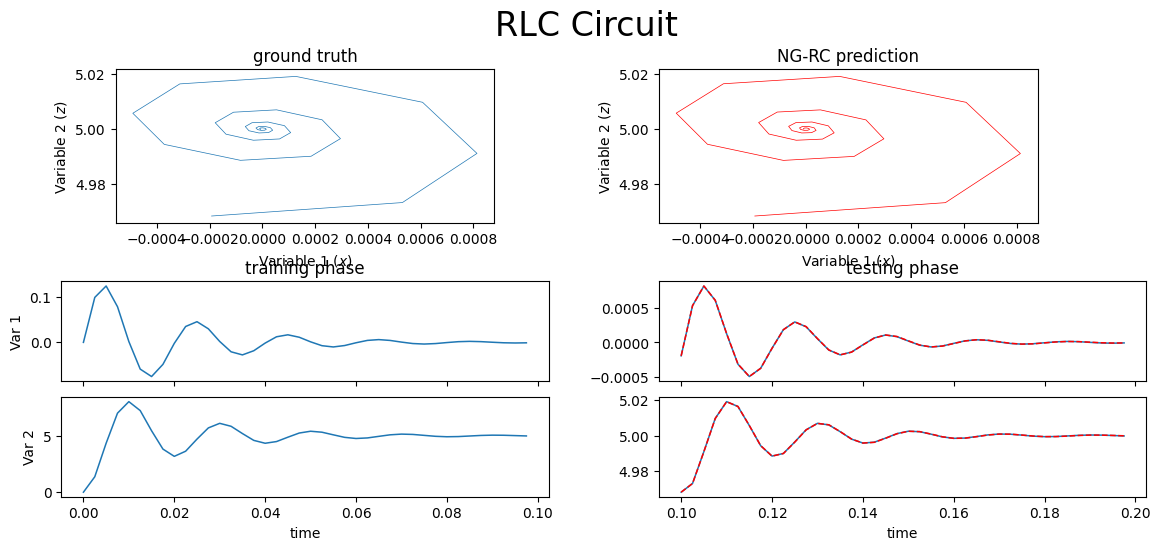

In [54]:
def rlc(t_span, dt, init_state=[0,0]):
    """
    Lotka–Volterra predator–prey model
    """
    def odes(t, y):
      u, v = y
      return [-100 * u - 10 * v + 50, 10000 * u]
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(odes, t_span, init_state, t_eval=t_eval, method='RK45')
    return sol.t, sol.y.T

# --- USER CONFIGURATION ---
SYSTEM = 'RLC Circuit'
TRAIN_TIME = 0.1
TEST_TIME = 0.1
dt = 0.0025
t, data = rlc((0, TRAIN_TIME + TEST_TIME), dt)
# Param d=3, k=2, poly=2
model = NextGenRC(d=3, k=2, s=1, poly_order=3, ridge_alpha=2.5e-6)

# --- SPLIT, TRAIN, FORECAST ---
train_idx = int(TRAIN_TIME / dt)
train_set = data[:train_idx]
model.train(train_set)

# Forecast using the last snippet of training data as the start
pred_steps = len(t) - train_idx
prediction = model.forecast(train_set[-(model.warmup+1):], pred_steps)

# --- PLOT RESULTS ---
plot_ng_rc_results(t, data, prediction, train_idx, system_name=SYSTEM)